In [1]:
# Modules

from torchvision import datasets
import numpy as np
from torchvision import utils
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import os
from torchsummary import summary
from torch import optim
import torch

In [2]:
path2data = "./data" #the location to download the data set

# train
train_data = datasets.MNIST(path2data, train=True, download=True) # veri setini indirme islemi

# train datasets
x_train = train_data.data 

# train labels
y_train = train_data.targets 

print(x_train.shape) # 60000 pieces number 28 * 28 size

print(y_train.shape) # 60000 labels

# test
val_data = datasets.MNIST(path2data, train=False, download=True)

# test datasets
x_val = val_data.data

# labels
y_val = val_data.targets

# 10000 pieces of 28 * 28 data
print(x_val.shape)

# 1000 labels
print(y_val.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [7]:
# 1, 28, 28
if len(x_train.shape)==3:
    x_train=x_train.unsqueeze(1)

print("Final version of the training dataset : ",x_train.shape)

if len(x_val.shape)==3:
    x_val=x_val.unsqueeze(1)

print("Final version of the labels : ",x_val.shape)

# data visualization
def show(img):

    npimg = img.numpy()

    npimg_tr=np.transpose(npimg, (1,2,0))
    
    plt.imshow(npimg_tr,interpolation='nearest')
    
    plt.show()

Final version of the training dataset :  torch.Size([60000, 1, 28, 28])
Final version of the labels :  torch.Size([10000, 1, 28, 28])


torch.Size([3, 152, 242])


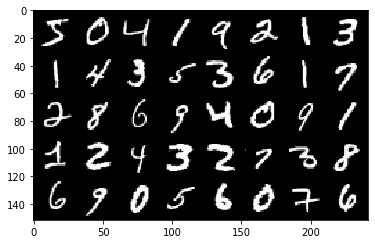

In [8]:

x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)
# visualizing data
show(x_grid)

torch.Size([1, 28, 28])


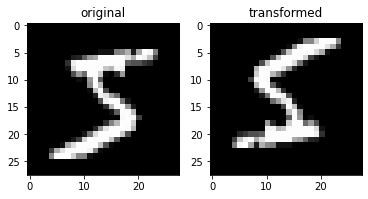

In [12]:
# We have defined class to implement some image transformations
# We enlarged our data set.
# Horizontal and vertical rotation probability set p = 1 to force rotation
data_transform = transforms.Compose([
transforms.RandomHorizontalFlip(p=1),
transforms.RandomVerticalFlip(p=1),
transforms.ToTensor(),
])

# Let's apply the transformations to an image in the MNIST dataset

# sample picture
img = train_data[0][0]


# we implement the transformation
img_tr=data_transform(img)

# Converting to tensor numpy array
img_tr_np=img_tr.numpy()

print(img_tr.shape)

# original and transformed image
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(img_tr_np[0],cmap="gray");
plt.title("transformed")
plt.show()

In [13]:
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

# We created data with 128 stacks
train_dl = DataLoader(train_ds, batch_size=128)
val_dl = DataLoader(val_ds, batch_size=128)


In [14]:
class demirnet(nn.Module):
    
    # layers, input and output sizes
    def __init__(self):
        
        # Tamamen bağlı katmanlar
        super(demirnet, self).__init__()
        self.fc1 = nn.Linear(784, 700)
        self.fc2 = nn.Linear(700, 500)
        self.fc3 = nn.Linear(500,400)
        self.fc4 = nn.Linear(400,300)
        self.fc5 = nn.Linear(300,200)
        self.fc6 = nn.Linear(200,80)
        self.fc7 = nn.Linear(80,10)
        
    
    # activation functions used in layers
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        
        return F.log_softmax(x, dim=1)

In [16]:
model = demirnet()

print(model) # Layers

device = torch.device("cpu:0")

print("Model = ",next(model.parameters()).device," da eğitilecek")

summary(model, input_size=(1,28,28)) # parameters of the model

# loss
loss_func = nn.NLLLoss(reduction="sum")

# optimization
opt = optim.Adam(model.parameters(), lr=1e-4)

demirnet(
  (fc1): Linear(in_features=784, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=300, bias=True)
  (fc5): Linear(in_features=300, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=80, bias=True)
  (fc7): Linear(in_features=80, out_features=10, bias=True)
)
Model =  cpu  da eğitilecek
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 500]         350,500
            Linear-3                  [-1, 400]         200,400
            Linear-4                  [-1, 300]         120,300
            Linear-5                  [-1, 200]          60,200
            Linear-6                   [-1, 80]          16,080
            Line

In [17]:
def metrics_batch(target, output):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class to target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

"""
Let's develop an auxiliary function to calculate the loss value per mini series, 128 stack
"""
def loss_batch(loss_func, xb, yb,yb_h, opt=None):
    
    # loss
    loss = loss_func(yb_h, yb)
    
    # obtain performance measurement
    metric_b = metrics_batch(yb,yb_h)
    
    if opt is not None:
        loss.backward() # recalculation according to model parameters
        opt.step() # updating model parameters
        opt.zero_grad() # setting gradients to zero

    return loss.item(), metric_b

"""
Next, we will define a loss and a helper function to calculate metric values."""
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    loss=0.0
    metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        
        # get model printout
        yb_h=model(xb)

        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
    loss/=len_data # average error in a loop
    metric/=len_data
    return loss, metric

In [18]:
# training cycle
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    
    for epoch in range(epochs):
        # informs that education has started
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)
        
        # reports training on verification data.
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        
        accuracy=100*val_metric
        
        #Information
        print("epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f" %(epoch, train_loss,val_loss,accuracy))


# function call process
num_epochs=8
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl)

# the location and name where the model will be saved
path2weights="./model/weights.pt"
# save the model.
torch.save(model.state_dict(), path2weights)

epoch: 0, train loss: 0.325799, val loss: 0.141077, accuracy: 95.73
epoch: 1, train loss: 0.113124, val loss: 0.108431, accuracy: 96.58
epoch: 2, train loss: 0.069388, val loss: 0.126622, accuracy: 95.99
epoch: 3, train loss: 0.048271, val loss: 0.120330, accuracy: 96.51
epoch: 4, train loss: 0.033397, val loss: 0.098137, accuracy: 97.24
epoch: 5, train loss: 0.024963, val loss: 0.111777, accuracy: 97.03
epoch: 6, train loss: 0.023394, val loss: 0.109953, accuracy: 97.22
epoch: 7, train loss: 0.014174, val loss: 0.092020, accuracy: 97.71


Pick a random number from 10000 data = 8


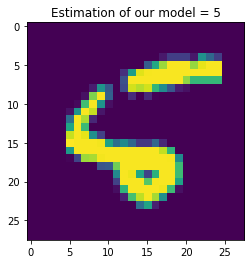

Pick a random number from 10000 data = 8000


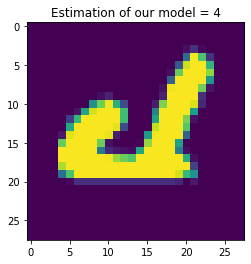

Pick a random number from 10000 data = 259


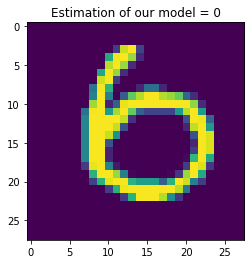

Pick a random number from 10000 data = 765


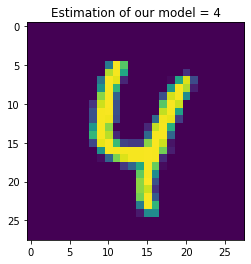

Pick a random number from 10000 data = q


In [20]:
data = datasets.MNIST(path2data, train=False, download=True) # datasets

x_train = data.data # our numbers

while True:

    try:

        a = int(input("Pick a random number from 10000 data = "))

    except:

        break

    if a > 9999 or a < 0:

        quit()

    x = x_train[a]

    x1 = x_train[a]


    x= x.unsqueeze(0)
    x= x.unsqueeze(0)

    x=x.type(torch.float)

    x=x.to(device)


    output=model(x)

    pred = output.argmax(dim=1, keepdim=True)
    z = pred.item()

    plt.imshow(x1)
    plt.title("Estimation of our model = {}".format(z))
    plt.show()